# Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [3]:
cd /gdrive/MyDrive/ThinkStats2/code

/gdrive/MyDrive/ThinkStats2/code


In [4]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

import random

import thinkstats2
import thinkplot

## Least squares

One more time, let's load up the NSFG data.

In [5]:
import first
live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])
ages = live.agepreg
weights = live.totalwgt_lb

The following function computes the intercept and slope of the least squares fit.

In [6]:
from thinkstats2 import Mean, MeanVar, Var, Std, Cov

def LeastSquares(xs, ys):
    meanx, varx = MeanVar(xs)
    meany = Mean(ys)

    slope = Cov(xs, ys, meanx, meany) / varx
    inter = meany - slope * meanx

    return inter, slope

Here's the least squares fit to birth weight as a function of mother's age.

In [7]:
inter, slope = LeastSquares(ages, weights)
inter, slope

(6.830396973311053, 0.017453851471802746)

The intercept is often easier to interpret if we evaluate it at the mean of the independent variable.

In [8]:
Mean(ages)

24.93612856826679

In [9]:
inter + slope * 25

7.266743260106122

And the slope is easier to interpret if we express it in pounds per decade (or ounces per year).

In [10]:
slope * 10

0.17453851471802745

The following function evaluates the fitted line at the given `xs`.

In [11]:
def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys

And here's an example.

In [12]:
fit_xs, fit_ys = FitLine(ages, inter, slope)

Here's a scatterplot of the data with the fitted line.

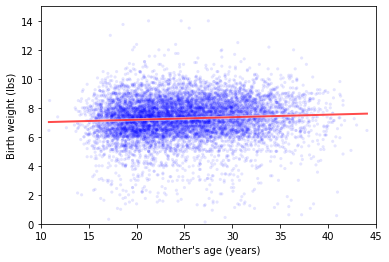

In [13]:
thinkplot.Scatter(ages, weights, color='blue', alpha=0.1, s=10)
thinkplot.Plot(fit_xs, fit_ys, color='white', linewidth=3)
thinkplot.Plot(fit_xs, fit_ys, color='red', linewidth=2)
thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Birth weight (lbs)',
                 axis=[10, 45, 0, 15],
                 legend=False)

## Residuals

The following functon computes the residuals.

In [14]:
def Residuals(xs, ys, inter, slope):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    res = ys - (inter + slope * xs)
    return res

Now we can add the residuals as a column in the DataFrame.

In [15]:
live['residual'] = Residuals(ages, weights, inter, slope)

To visualize the residuals, I'll split the respondents into groups by age, then plot the percentiles of the residuals versus the average age in each group.

First I'll make the groups and compute the average age in each group.

In [16]:
bins = np.arange(10, 48, 3)
indices = np.digitize(live.agepreg, bins)
groups = live.groupby(indices)

age_means = [group.agepreg.mean() for _, group in groups][1:-1]
age_means

[15.212333333333312,
 17.74035928143719,
 20.506304824561838,
 23.455752212389893,
 26.435156146179903,
 29.411177432543294,
 32.30232530120497,
 35.240273631840736,
 38.10876470588231,
 40.91205882352941]

Next I'll compute the CDF of the residuals in each group.

In [17]:
cdfs = [thinkstats2.Cdf(group.residual) for _, group in groups][1:-1]

The following function plots percentiles of the residuals against the average age in each group.

In [18]:
def PlotPercentiles(age_means, cdfs):
    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(age_means, weight_percentiles, label=label)

The following figure shows the 25th, 50th, and 75th percentiles.

Curvature in the residuals suggests a non-linear relationship.

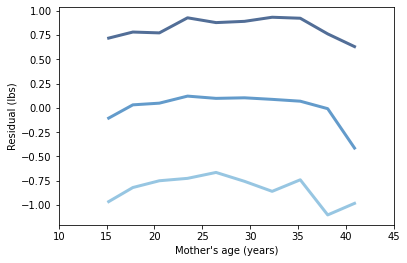

In [19]:
PlotPercentiles(age_means, cdfs)

thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Residual (lbs)',
                 xlim=[10, 45])

## Sampling distribution

To estimate the sampling distribution of `inter` and `slope`, I'll use resampling.

In [20]:
def SampleRows(df, nrows, replace=False):
    """Choose a sample of rows from a DataFrame.

    df: DataFrame
    nrows: number of rows
    replace: whether to sample with replacement

    returns: DataDf
    """
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

def ResampleRows(df):
    """Resamples rows from a DataFrame.

    df: DataFrame

    returns: DataFrame
    """
    return SampleRows(df, len(df), replace=True)

The following function resamples the given dataframe and returns lists of estimates for `inter` and `slope`.

In [21]:
def SamplingDistributions(live, iters=101):
    t = []
    for _ in range(iters):
        sample = ResampleRows(live)
        ages = sample.agepreg
        weights = sample.totalwgt_lb
        estimates = LeastSquares(ages, weights)
        t.append(estimates)

    inters, slopes = zip(*t)
    return inters, slopes

Here's an example.

In [22]:
inters, slopes = SamplingDistributions(live, iters=1001)

The following function takes a list of estimates and prints the mean, standard error, and 90% confidence interval.

In [23]:
def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)

Here's  the summary for `inter`.

In [24]:
Summarize(inters)

mean, SE, CI 6.8299651898571305 0.07158395791765554 (6.712445661387877, 6.9476527079892305)


And for `slope`.

In [25]:
Summarize(slopes)

mean, SE, CI 0.01745329519961814 0.002792971279831586 (0.01285338241728815, 0.021940554033915042)


**Exercise:** Use `ResampleRows` and generate a list of estimates for the mean birth weight.  Use `Summarize` to compute the SE and CI for these estimates.

In [26]:
# Solution goes here
means = [Mean(ResampleRows(live).totalwgt_lb) for _ in range(1000)]

In [27]:
Summarize(means)

mean, SE, CI 7.265927085638416 0.015247621937559122 (7.2390324186766986, 7.289596702810356)


## Visualizing uncertainty

To show the uncertainty of the estimated slope and intercept, we can generate a fitted line for each resampled estimate and plot them on top of each other.

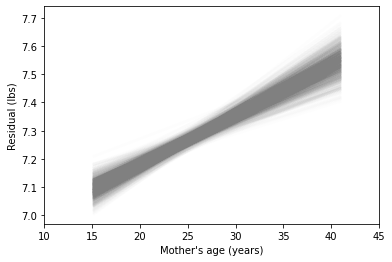

In [28]:
for slope, inter in zip(slopes, inters):
    fxs, fys = FitLine(age_means, inter, slope)
    thinkplot.Plot(fxs, fys, color='gray', alpha=0.01)
    
thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Residual (lbs)',
                 xlim=[10, 45])

Or we can make a neater (and more efficient plot) by computing fitted lines and finding percentiles of the fits for each value of the dependent variable.

In [29]:
def PlotConfidenceIntervals(xs, inters, slopes, percent=90, **options):
    fys_seq = []
    for inter, slope in zip(inters, slopes):
        fxs, fys = FitLine(xs, inter, slope)
        fys_seq.append(fys)

    p = (100 - percent) / 2
    percents = p, 100 - p
    low, high = thinkstats2.PercentileRows(fys_seq, percents)
    thinkplot.FillBetween(fxs, low, high, **options)

In [30]:
thinkstats2.PercentileRows??

This example shows the confidence interval for the fitted values at each mother's age.

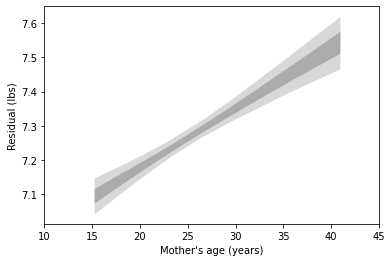

In [31]:
PlotConfidenceIntervals(age_means, inters, slopes, percent=90, 
                        color='gray', alpha=0.3, label='90% CI')
PlotConfidenceIntervals(age_means, inters, slopes, percent=50,
                        color='gray', alpha=0.5, label='50% CI')

thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Residual (lbs)',
                 xlim=[10, 45])

## Coefficient of determination



The coefficient compares the variance of the residuals to the variance of the dependent variable.

In [32]:
def CoefDetermination(ys, res):
    return 1 - Var(res) / Var(ys)

For birth weight and mother's age $R^2$ is very small, indicating that the mother's age predicts a small part of the variance in birth weight.

In [33]:
inter, slope = LeastSquares(ages, weights)
res = Residuals(ages, weights, inter, slope)
r2 = CoefDetermination(weights, res)
r2

0.004738115474710258

We can confirm that $R^2 = \rho^2$:

In [34]:
print('rho', thinkstats2.Corr(ages, weights))
print('R', np.sqrt(r2))    

rho 0.06883397035410904
R 0.06883397035410828


To express predictive power, I think it's useful to compare the standard deviation of the residuals to the standard deviation of the dependent variable, as a measure RMSE if you try to guess birth weight with and without taking into account mother's age.

In [35]:
print('Std(ys)', Std(weights))
print('Std(res)', Std(res))

Std(ys) 1.40821553384062
Std(res) 1.4048754287857834


As another example of the same idea, here's how much we can improve guesses about IQ if we know someone's SAT scores.

In [37]:
var_ys = 15**2
rho = 0.72
r2 = rho**2
var_res = (1 - r2) * var_ys
std_res = np.sqrt(var_res)
std_res

10.409610943738484

## Hypothesis testing with slopes

Here's a `HypothesisTest` that uses permutation to test whether the observed slope is statistically significant.

In [38]:
class SlopeTest(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        ages, weights = data
        _, slope = thinkstats2.LeastSquares(ages, weights)
        return slope

    def MakeModel(self):
        _, weights = self.data
        self.ybar = weights.mean()
        self.res = weights - self.ybar

    def RunModel(self):
        ages, _ = self.data
        weights = self.ybar + np.random.permutation(self.res)
        return ages, weights

In [39]:
thinkstats2.HypothesisTest??

And it is.

In [40]:
ht = SlopeTest((ages, weights))
pvalue = ht.PValue()
pvalue

0.0

Under the null hypothesis, the largest slope we observe after 1000 tries is substantially less than the observed value.

In [41]:
ht.actual, ht.MaxTestStat()

(0.017453851471802746, 0.008716447426964057)

We can also use resampling to estimate the sampling distribution of the slope.

In [42]:
slopes[:10]

(0.019905051666749687,
 0.0161477155887071,
 0.01957720120501088,
 0.018188164328954093,
 0.018276393651782345,
 0.018257507407252523,
 0.01561343364483129,
 0.015945196651702208,
 0.014337732279445367,
 0.018325472933175123)

In [43]:
sampling_cdf = thinkstats2.Cdf(slopes)

The distribution of slopes under the null hypothesis, and the sampling distribution of the slope under resampling, have the same shape, but one has mean at 0 and the other has mean at the observed slope.

To compute a p-value, we can count how often the estimated slope under the null hypothesis exceeds the observed slope, or how often the estimated slope under resampling falls below 0.

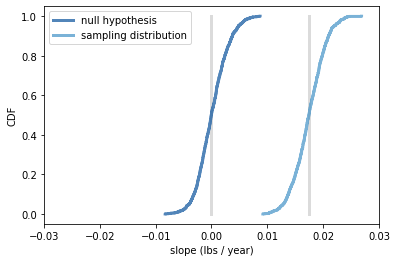

In [44]:
thinkplot.PrePlot(2)
thinkplot.Plot([0, 0], [0, 1], color='0.8')
ht.PlotCdf(label='null hypothesis')

thinkplot.Cdf(sampling_cdf, label='sampling distribution')

thinkplot.Config(xlabel='slope (lbs / year)',
                   ylabel='CDF',
                   xlim=[-0.03, 0.03],
                   legend=True, loc='upper left')

Here's how to get a p-value from the sampling distribution.

In [45]:
pvalue = sampling_cdf[0]
pvalue

0

## Resampling with weights

Resampling provides a convenient way to take into account the sampling weights associated with respondents in a stratified survey design.

The following function resamples rows with probabilities proportional to weights.

In [46]:
def ResampleRowsWeighted(df, column='finalwgt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

We can use it to estimate the mean birthweight and compute SE and CI.

In [47]:
iters = 100
estimates = [ResampleRowsWeighted(live).totalwgt_lb.mean()
             for _ in range(iters)]
Summarize(estimates)

mean, SE, CI 7.3465289610533295 0.014666230675467361 (7.32025199159106, 7.367151194954636)


And here's what the same calculation looks like if we ignore the weights.

In [48]:
estimates = [thinkstats2.ResampleRows(live).totalwgt_lb.mean()
             for _ in range(iters)]
Summarize(estimates)

mean, SE, CI 7.265270040385042 0.014047067388857649 (7.243880006638637, 7.289403075901748)


The difference is non-negligible, which suggests that there are differences in birth weight between the strata in the survey.

{'xscale': 'linear', 'yscale': 'linear'}

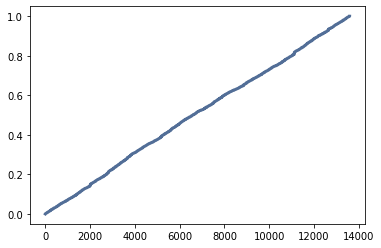

In [50]:
thinkplot.Cdf(thinkstats2.Cdf(dict(live['finalwgt'])))

In [55]:
live.finalwgt.head(3)

0     6448.271112
1     6448.271112
2    12999.542264
Name: finalwgt, dtype: float64

In [56]:
dict(live.finalwgt.head(3))

{0: 6448.271111704751, 1: 6448.271111704751, 2: 12999.5422643859}

{'xscale': 'linear', 'yscale': 'linear'}

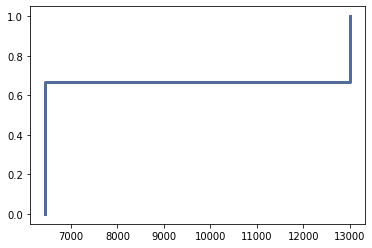

In [57]:
thinkplot.Cdf(thinkstats2.Cdf(live.finalwgt.head(3)))

In [60]:
thinkstats2.Cdf(live.finalwgt.head(3).values.tolist())

Cdf([ 6448.2711117  12999.54226439], [0.66666667 1.        ])

In [54]:
live.finalwgt.describe()

count      9038.000000
mean       8387.715697
std        9113.067252
min         118.656790
25%        3998.996257
50%        6416.070865
75%        9549.864303
max      261879.953864
Name: finalwgt, dtype: float64

In [61]:
thinkstats2.Cdf.ValueArray?

# Exercises

**Exercise:** Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much would it help to know their height?

Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimates?

Read the BRFSS data and extract heights and log weights.

In [62]:
import brfss

df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

Estimate intercept and slope.

In [65]:
# Solution goes here
i, s = LeastSquares(heights, log_weights)

In [66]:
i, s

(0.9930804163917626, 0.005281454169418102)

Make a scatter plot of the data and show the fitted line.

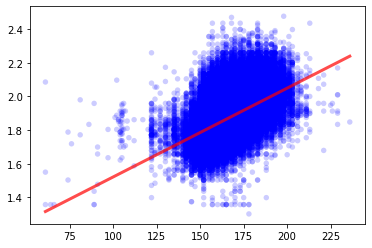

In [69]:
# Solution goes here
thinkplot.Scatter(heights, log_weights)
thinkplot.Plot(*FitLine(heights, i, s), color='red')

Make the same plot but apply the inverse transform to show weights on a linear (not log) scale.

In [ ]:
# Solution goes here

Plot percentiles of the residuals.

In [75]:
# Solution goes here
df['residuals'] = Residuals(heights, log_weights, i, s)
bins = np.arange(130, 210, 5)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

In [76]:
height_means = [g.htm3.mean() for _, g in groups]
height_means

[115.25714285714285,
 130.8842105263158,
 135.78508771929825,
 141.43396226415095,
 146.33718778908417,
 151.52843968228584,
 156.3503419942746,
 161.67421045177736,
 166.56972746679975,
 171.40954232482787,
 176.54908086026674,
 181.57596142807944,
 186.32469990536435,
 191.7859712230216,
 196.6426561620709,
 201.73827160493826,
 210.58778625954199]

In [77]:
cdfs = [thinkstats2.Cdf(g.residuals) for _, g in groups]

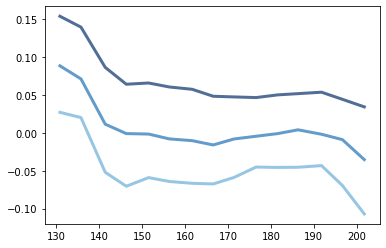

In [79]:
PlotPercentiles(height_means[1:-1], cdfs[1:-1])

Compute correlation.

In [81]:
# Solution goes here
rho = thinkstats2.Corr(heights, log_weights)
rho

0.5317282605983583

Compute coefficient of determination.

In [82]:
# Solution goes here
r2 = thinkstats2.CoefDetermination(log_weights, df.residuals)

Confirm that $R^2 = \rho^2$.

In [85]:
r2, rho**2

(0.28273494311894365, 0.28273494311895564)

Compute Std(ys), which is the RMSE of predictions that don't use height.

In [88]:
# Solution goes here
y_std = thinkstats2.Std(log_weights); y_std

0.10320725030004982

Compute Std(res), the RMSE of predictions that do use height.

In [89]:
# Solution goes here
res_std = thinkstats2.Std(df.residuals); res_std

0.08740777080416141

How much does height information reduce RMSE?

In [90]:
# Solution goes here
(y_std - res_std) / y_std

0.15308497658793627

Use resampling to compute sampling distributions for inter and slope.

In [ ]:
# Solution goes here

Plot the sampling distribution of slope.

In [ ]:
# Solution goes here

Compute the p-value of the slope.

In [ ]:
# Solution goes here

Compute the 90% confidence interval of slope.

In [ ]:
# Solution goes here

Compute the mean of the sampling distribution.

In [93]:
# Solution goes here
slopes = []
for _ in range(100):
    sample = thinkstats2.ResampleRows(df)
    slopes.append(thinkstats2.LeastSquares(sample.htm3, np.log10(sample.wtkg2))[1])

Summarize(slopes)

mean, SE, CI 0.0052824103372923915 1.3303720389689816e-05 (0.005257435291519512, 0.0053040932585893845)


Compute the standard deviation of the sampling distribution, which is the standard error.

In [ ]:
# Solution goes here

Resample rows without weights, compute mean height, and summarize results.

In [91]:
# Solution goes here
Summarize([thinkstats2.ResampleRows(df).htm3.mean() for _ in range(100)])

mean, SE, CI 168.95617534711695 0.015733434454842092 (168.92561743365872, 168.97839234826895)


Resample rows with weights.  Note that the weight column in this dataset is called `finalwt`.

In [92]:
# Solution goes here
Summarize([thinkstats2.ResampleRowsWeighted(df, 'finalwt').htm3.mean() for _ in range(100)])

mean, SE, CI 170.4943263556256 0.017670377467731698 (170.4647148285131, 170.5220472321591)
